In [222]:
import qibo
import numpy as np
import matplotlib.pyplot as plt
from qibo.noise import IBMQNoiseModel
from scipy.optimize import minimize, minimize_scalar

from qibochem.driver.molecule import Molecule
from qibochem.ansatz import hf_circuit, ucc_circuit
from qibochem.measurement import expectation, expectation_from_samples
from qibochem.ansatz import he_circuit

from qibo.hamiltonians import SymbolicHamiltonian

from qibochem.driver.hamiltonian import fermionic_hamiltonian

from openfermion.transforms import *
from openfermion.transforms import binary_code_transform
from openfermion.transforms import get_fermion_operator
from openfermion.utils import up_then_down

from functools import reduce
from qibo import symbols
from tqdm import tqdm

In [2]:
qibo.set_backend("numpy")

[Qibo 0.2.9|INFO|2024-10-15 17:45:18]: Using numpy backend on /CPU:0


In [3]:
from IPython.utils.io import capture_output
def block_print(func):
    def func_wrapper(*args, **kwargs):
        with capture_output():
            value = func(*args, **kwargs)
        return value
    return func_wrapper

In [140]:
@block_print
def h2(x):
    molecule = Molecule([('H', (0, 0, 0)), ('H', (0, 0, x))])
    molecule.run_pyscf()
    return molecule

# https://quantumai.google/openfermion/tutorials/binary_code_transforms
def parity_mapped_hamiltonian(molecule):
    hamiltonian = fermionic_hamiltonian(molecule.oei, molecule.tei, molecule.e_nuc)
    hamiltonian = get_fermion_operator(hamiltonian)
    hamiltonian = binary_code_transform(reorder(hamiltonian,up_then_down), 2*checksum_code(2,1))
    symbolic_ham = sum(
        reduce(lambda x, y: x * y, (getattr(symbols, pauli_op)(qubit) for qubit, pauli_op in pauli_string), coeff)
        # Sums over each individual Pauli string in the QubitOperator
        for operator in hamiltonian.get_operators()
        # .terms gives one operator as a single-item dictionary, e.g. {((1: "X"), (2: "Y")): 0.33}
        for pauli_string, coeff in operator.terms.items()
    )
    return SymbolicHamiltonian(symbolic_ham)

In [141]:
molecule = h2(0.7)
hamiltonian = parity_mapped_hamiltonian(molecule)
print(hamiltonian.form)

In [144]:
nlayers = 1
nqubits = hamiltonian.nqubits
ntheta = 2 * nqubits * nlayers
circuit = he_circuit(2, nlayers)
print(circuit.draw())

q0: ─RY─RZ─o─Z─
q1: ─RY─RZ─Z─o─


In [241]:
def energy(x, theta, circuit):
    if type(x) != np.float64:
        x, theta = theta, x
        
    molecule = h2(x)
    hamiltonian = parity_mapped_hamiltonian(molecule)

    circuit.set_parameters(theta)
    # samples = expectation_from_samples(circuit, hamiltonian, n_shots=8096)
    exact = expectation(circuit, hamiltonian)
    return exact

In [293]:
@block_print
def optimize(circuit, tolerance: float = 1e-5, max_iter: int = 30):
    vqe_energy, bond_length = [], []
    
    theta, x = np.random.uniform(0, 2 * np.pi, 4), np.float64(1.0)
    cur = prev = energy(x, theta, circuit)
    
    it = 0
    with tqdm(total=0, desc="Optimizing") as pbar:
        while it < max_iter:
            result = minimize(energy, theta, args=(x, circuit), method="BFGS", options={'maxiter': 1})
            theta = result.x
            
            result = minimize_scalar(energy, bounds=(0, 2), args=(theta, circuit), options={'maxiter': 5})
            x = result.x
            
            cur = energy(x, theta, circuit)
            delta = abs(cur - prev)
            
            pbar.set_postfix({
                'E': f"{cur:.6f}",
                'x': f"{x:.6f}",
                'delta': f"{delta:.6f}"
            })
            
            if delta < tolerance:
                break
            
            vqe_energy.append(cur)
            bond_length.append(x)
            prev = cur
            it += 1
            pbar.update(1)

        pbar.close()
        
    return cur, x, vqe_energy, bond_length, it

In [244]:
_, _, vqe_energy, bond_length, it = optimize(circuit)

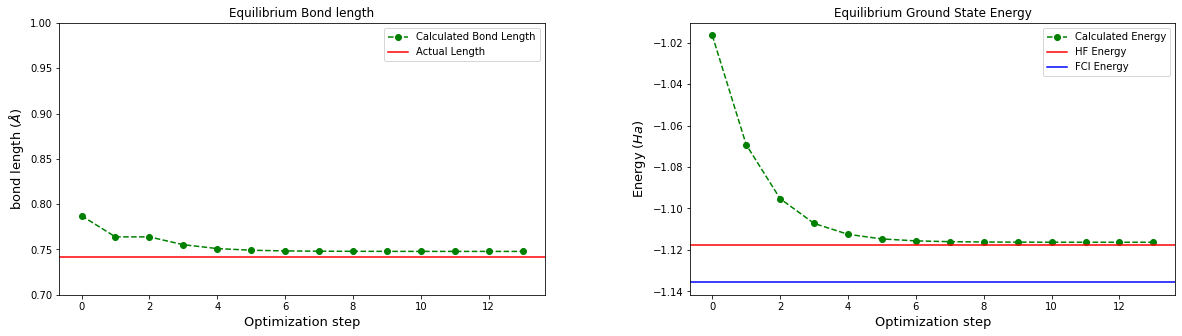

In [236]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, it), bond_length, "go", ls="dashed", label="Calculated Bond Length")
ax1.axhline(y=0.7414, color='r', label="Actual Length") # https://cccbdb.nist.gov/exp2x.asp?casno=1333740
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("bond length ($\AA$)", fontsize=13)
ax1.title.set_text("Equilibrium Bond length")
ax1.set_ylim([0.70, 1.0])
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, it), vqe_energy, "go", ls="dashed", label="Calculated Energy")
ax2.axhline(y=-1.1176, color='r', label="HF Energy")
ax2.axhline(y=-1.1357, color='b', label="FCI Energy") # https://pennylane.ai/qml/demos/tutorial_vqe/
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Energy ($Ha$)", fontsize=13)
ax2.title.set_text("Equilibrium Ground State Energy")
ax2.legend()

plt.subplots_adjust(wspace=0.3)
plt.show()

In [304]:
distances = np.arange(0.2, 3.51, 0.01)
scf_energy, vqe_energy = [], []

for x in tqdm(distances, desc="Calculating energies"):
    molecule = h2(x)
    scf_energy.append(molecule.e_hf)
    
    theta = np.random.uniform(0, 2 * np.pi, 4)
    result = minimize(energy, theta, args=(x, circuit), method="BFGS", options={'maxiter': 100})
    vqe_energy.append(result.fun)

Calculating energies: 100%|██████████| 331/331 [08:39<00:00,  1.57s/it]


In [307]:
vqe_energy = np.array(vqe_energy)
distances[vqe_energy.argmin()]

0.7100000000000004

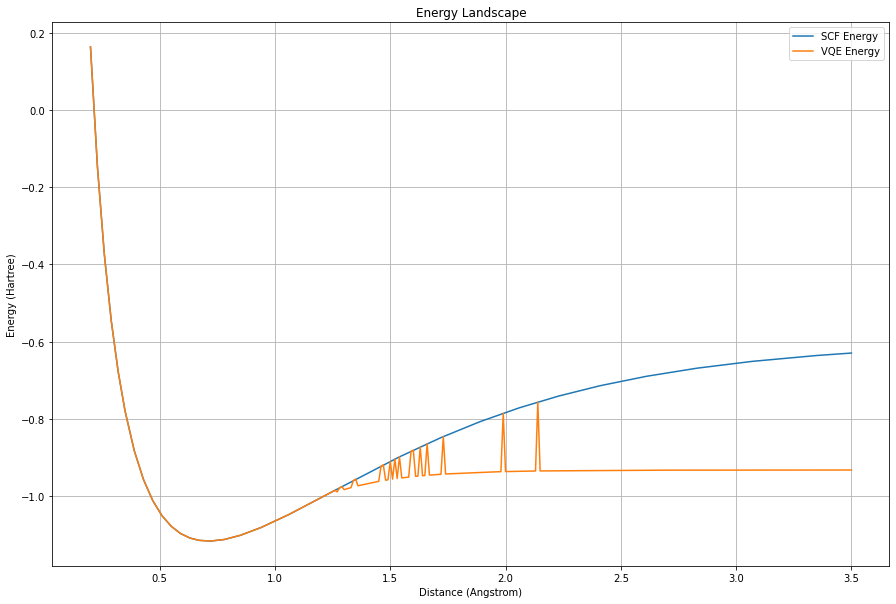

In [305]:
plt.figure(figsize=(15, 10))
plt.plot(distances, scf_energy, label="SCF Energy")
plt.plot(distances, vqe_energy, label="VQE Energy")

plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Landscape')
plt.legend()
plt.grid(True)
plt.show()

In [319]:
accuracies = np.logspace(0, 15, num=50, base=1.4)
vqe_energies, bond_lengths = [], []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    parameters = {
        "t1": accuracy * 1e-6,
        "t2": accuracy * 0.5e-6,
        "gate_times" : (40e-9, 150e-9),
        "excited_population" : 0,
        "depolarizing_one_qubit" : 0,
        "depolarizing_two_qubit": 0,
        "readout_one_qubit" : {"0": 0, "1": 0},
    }
    
    noise_model = IBMQNoiseModel()
    noise_model.from_dict(parameters)
    noisy_circuit = noise_model.apply(circuit)
    noisy_circuit.density_matrix = True
    
    vqe_energy, x, _, _, _ = optimize(noisy_circuit, tolerance=1e-5)
    vqe_energies.append(vqe_energy)
    bond_lengths.append(x)

Evaluating simulation: 100%|██████████| 50/50 [05:09<00:00,  6.19s/it]


In [309]:
 import pandas as pd

df = pd.DataFrame({"energy": vqe_energies, "x": bond_lengths})
df.to_csv("energy_acc_qibo.csv", index=False)

# df = pd.read_csv("energy_acc_qibo.csv")
# vqe_energies, bond_lengths = df["energy"], df["x"]

KeyError: 'x'

In [285]:
parameters = {
    "t1": 1000 * 1e-6,
    "t2": 1000 * 0.5e-6,
    "gate_times" : (40e-9, 150e-9),
    "excited_population" : 0,
    "depolarizing_one_qubit" : 0,
    "depolarizing_two_qubit": 0,
    "readout_one_qubit" : {"0": 0, "1": 0},
}

noise_model = IBMQNoiseModel()
noise_model.from_dict(parameters)
noisy_circuit = noise_model.apply(circuit)
noisy_circuit.density_matrix = True

vqe_energy, x, _, _, _ = optimize(noisy_circuit, tolerance=1e-6)
vqe_energy, x

Optimizing: 23it [00:07,  2.98it/s, E=-1.115687, x=0.748359, delta=0.000001]


(-1.115686548873237, 0.7483585893616853)

In [320]:
from scipy.optimize import curve_fit

def func(x, a, b, c, p):
  return (a * np.exp(-b * x)) / np.sqrt(x + c) + p

params, _ = curve_fit(func, accuracies, vqe_energies, p0=(1, 1, 1, 0), bounds=([-5] * 4, [5] * 4), maxfev=10000)
a, b, c, p = params
y_fit = func(accuracies, *params)
print(*params)

0.34663711301750605 0.08601624320542053 -0.19636442918637553 -1.1063546276702043


In [321]:
from sklearn.metrics import r2_score
r2_score(vqe_energies, y_fit)

0.9985529854563852

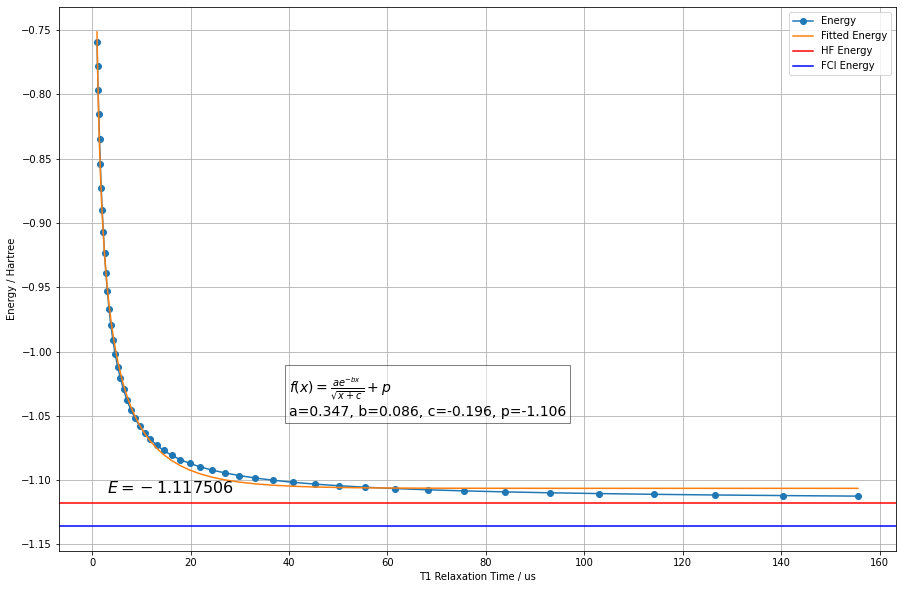

In [322]:
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, vqe_energies, 'o-', label="Energy")
plt.plot(accuracies, y_fit, label="Fitted Energy")
equation_text = r'$f(x) = \frac{{ae^{{-bx}}}}{{\sqrt{{x + c}}}} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, p={p:.3f}'
plt.text(40, -1.05, equation_text + '\n' + params_text, fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
plt.text(3, -1.11, r'$E = -1.117506$', fontsize=16)
plt.axhline(y=-1.1176, color='r', label="HF Energy")
plt.axhline(y=-1.1357, color='b', label="FCI Energy")
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()

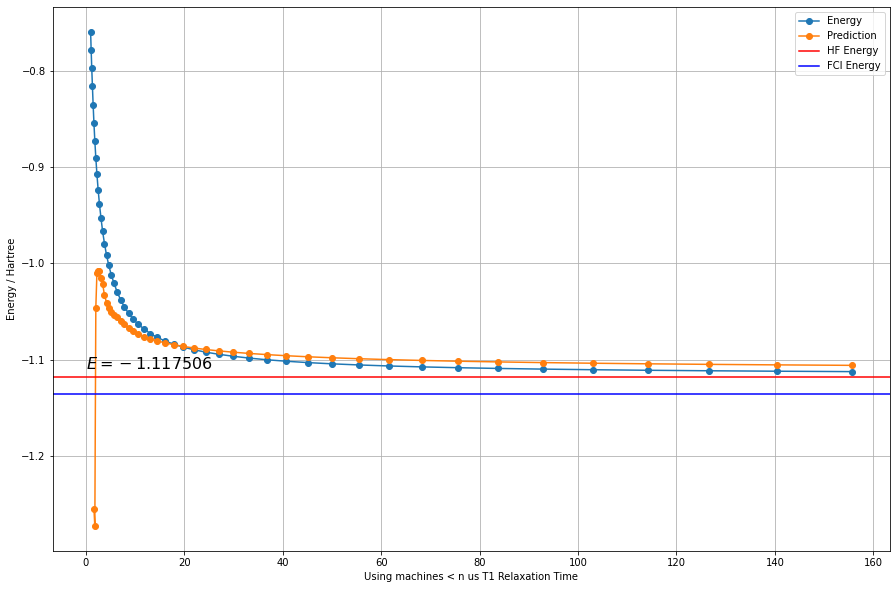

In [324]:
guesses = []
for limit in range(5, 50):
  params, _ = curve_fit(func, accuracies[:limit], vqe_energies[:limit],
                        p0=(1, 1, 1, 0), bounds=([-5] * 4, [5] * 4), maxfev=10000)
  a, b, c, p = params
  guesses.append(p)

guesses = np.array(guesses)
plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, vqe_energies, 'o-', label="Energy")
plt.text(0, -1.11, r'$E = -1.117506$', fontsize=16)
plt.plot(accuracies[5:], guesses, 'o-', label="Prediction")
plt.axhline(y=-1.1176, color='r', label="HF Energy")
plt.axhline(y=-1.1357, color='b', label="FCI Energy")
plt.xlabel('Using machines < n us T1 Relaxation Time')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend()
plt.show()